In [1]:
from bggcomplex import *
from lie_algebra_module import *
import numpy as np
from collections import Counter

In [2]:
BGG = BGGComplex("G2")
BGG.find_cycles();

In [3]:
Solver = BGGMapSolver(BGG,BGG.zero_root)

In [4]:
Solver.solve(parallel=False);

In [5]:
print(Solver.timer)

{'index': 0.002064943313598633, 'vect': 0.005892753601074219, 'basis': 0.002888202667236328, 'mult': 0.01994919776916504, 'linalg': 0.07541108131408691}


In [6]:
Solver.check_maps()

checked 32 cycles, with no problems found!


In [7]:
BGG.compute_signs()

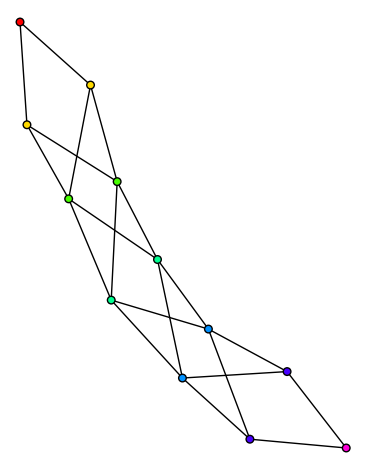

In [8]:
BGG.plot_graph().plot()

In [9]:
roots=BGG.W.domain().simple_roots()
roots

Finite family {1: (0, 1, -1), 2: (1, -2, 1)}

In [10]:
dom = BGG.W.domain()
cr= dom.coroot_lattice()

In [11]:
fun=dom.fundamental_weights_from_simple_roots()
fun

Finite family {1: (1, 0, -1), 2: (2, -1, -1)}

In [12]:
dom.simple_coroots()

Finite family {1: (0, 1, -1), 2: (1/3, -2/3, 1/3)}

In [13]:
[BGG._weight_to_tuple(r) for r in fun.values()]

[[2, 1], [3, 2]]

In [14]:
dom = BGG.W.domain()
dom.simple_coroots()

Finite family {1: (0, 1, -1), 2: (1/3, -2/3, 1/3)}

In [15]:
dom.simple_roots()

Finite family {1: (0, 1, -1), 2: (1, -2, 1)}

In [16]:
BGG._tuple_to_weight([1,1,1/2])

(1, -1, 0)

In [17]:
mu=fun[1]

In [18]:
mu = BGG.zero_root

In [19]:
[BGG._tuple_to_weight(BGG.dot_action(w,mu))-mu for w in BGG.W]

[(0, 0, 0),
 (-5, 4, 1),
 (-4, -1, 5),
 (-1, 2, -1),
 (-6, 3, 3),
 (-2, -2, 4),
 (0, -1, 1),
 (-5, 0, 5),
 (-4, 4, 0),
 (-1, -2, 3),
 (-6, 2, 4),
 (-2, 3, -1)]

In [20]:
def is_dot_regular(mu):
    stab_counter = 0
    for w in BGG.W:
        if w.action(mu+BGG.rho)-BGG.rho==mu:
            stab_counter+=1
    if stab_counter<=1:
        return True
    else:
        return False

In [21]:
(BGG.rho-fun[1]).is_dominant()

True

In [22]:
#mu=(5*BGG.simple_roots[1]+6*BGG.simple_roots[2]+5*BGG.simple_roots[3])
#print(mu.is_dominant())
#print(BGG.is_dot_regular(mu))

In [23]:
#BGG.make_dominant(mu)

We want to implement the $U(\mathfrak g)$ action on the module
$$
    M_i^j=\bigoplus{}_{r=0}^{j+\frac k2}\left(\left(\bigodot{}^{j+\frac k2-r}\mathfrak u \right)\otimes\left(\bigwedge^r\mathfrak g\right)\otimes\left(\bigwedge{}^{j+\frac k2}\mathfrak n \right) \right)
$$
For this we need two things, one is finding a basis of this module, and second we define the action on it. Unfortunately I can't find a good out of the box implementation for either of these, so we are going to have to do it ourselves. Ideally we can use this to extend sage a little bit. 

Sagemath has a class FreeModuleTensor, it can deal with alternating and symmetric tensors. But it specifically says it can not deal with tensor products of different modules, whereas that is precisely what we need. We should investigate how this class work, and extend it with this functionality. Besides, that module seems to focus on doing stuff without a specific basis. We want to do everything in a basis, because the whole point is to compute a basis. 

We should make an instance of CombinatorialFreeModule

In [24]:
{tuple(a):a for a in BGG.LA.basis().keys()}

{((1, -3), (2, -2)): -3*alpha[1] - 2*alpha[2],
 ((1, -3), (2, -1)): -3*alpha[1] - alpha[2],
 ((1, -2), (2, -1)): -2*alpha[1] - alpha[2],
 ((1, -1),): -alpha[1],
 ((1, -1), (2, -1)): -alpha[1] - alpha[2],
 ((1, 1),): alphacheck[1],
 ((1, 1), (2, 1)): alpha[1] + alpha[2],
 ((1, 2), (2, 1)): 2*alpha[1] + alpha[2],
 ((1, 3), (2, 1)): 3*alpha[1] + alpha[2],
 ((1, 3), (2, 2)): 3*alpha[1] + 2*alpha[2],
 ((2, -1),): -alpha[2],
 ((2, 1),): alphacheck[2]}

In [25]:
 BGG.W.domain().roots()

[(0, 1, -1),
 (1, -2, 1),
 (1, -1, 0),
 (1, 0, -1),
 (1, 1, -2),
 (2, -1, -1),
 (0, -1, 1),
 (-1, 2, -1),
 (-1, 1, 0),
 (-1, 0, 1),
 (-1, -1, 2),
 (-2, 1, 1)]

In [26]:
def root_dict_to_string(root_dict):
    return ''.join(''.join([str(k)]*abs(v)) for k,v in root_dict.items())

string_to_root = {}
for i,b in dict(BGG.lattice.alphacheck()).items():
    string_to_root['h%d'%i]=b
for a in BGG.lattice.negative_roots():
    key = 'f'+root_dict_to_string(a.monomial_coefficients())
    string_to_root[key]=a 
for a in BGG.lattice.positive_roots():
    key = 'e'+root_dict_to_string(a.monomial_coefficients())
    string_to_root[key]=a  

root_to_string = {r:i for i,r in string_to_root.items()}
string_to_root

{'e1': alpha[1],
 'e1112': 3*alpha[1] + alpha[2],
 'e11122': 3*alpha[1] + 2*alpha[2],
 'e112': 2*alpha[1] + alpha[2],
 'e12': alpha[1] + alpha[2],
 'e2': alpha[2],
 'f1': -alpha[1],
 'f1112': -3*alpha[1] - alpha[2],
 'f11122': -3*alpha[1] - 2*alpha[2],
 'f112': -2*alpha[1] - alpha[2],
 'f12': -alpha[1] - alpha[2],
 'f2': -alpha[2],
 'h1': alphacheck[1],
 'h2': alphacheck[2]}

In [27]:
gbasis_dict = {str(i):r for i,r in enumerate(BGG.LA.basis().keys())}
root_to_index = {r:i for i,r in gbasis_dict.items()}
root_to_index

{alphacheck[1]: '6',
 alphacheck[2]: '7',
 -3*alpha[1] - 2*alpha[2]: '13',
 -3*alpha[1] - alpha[2]: '12',
 -2*alpha[1] - alpha[2]: '11',
 -alpha[1]: '9',
 -alpha[1] - alpha[2]: '10',
 alpha[1]: '1',
 alpha[1] + alpha[2]: '2',
 2*alpha[1] + alpha[2]: '3',
 3*alpha[1] + alpha[2]: '4',
 3*alpha[1] + 2*alpha[2]: '5',
 -alpha[2]: '8',
 alpha[2]: '0'}

In [28]:
dom = BGG.W.domain()
dom.positive_roots()

[(0, 1, -1), (1, -2, 1), (1, -1, 0), (1, 0, -1), (1, 1, -2), (2, -1, -1)]

# Lie algebra modules

In [29]:
factory = LieAlgebraModuleFactory(BGG.LA)
M1=factory.construct_module(subalgebra='n')
M2=factory.construct_module(subalgebra='b')
M3 = M1.alternating_power(3)

In [30]:
LieAlgebraModule.direct_sum(M1.alternating_power(3),M2.symmetric_power(3))

Free module generated by {f1∧f1112∧f11122, f1∧f1112∧f112, f1∧f1112∧f12, f1∧f1112∧f2, f1∧f11122∧f112, f1∧f11122∧f12, f1∧f11122∧f2, f1∧f112∧f12, f1∧f112∧f2, f1∧f12∧f2, f1112∧f11122∧f112, f1112∧f11122∧f12, f1112∧f11122∧f2, f1112∧f112∧f12, f1112∧f112∧f2, f1112∧f12∧f2, f11122∧f112∧f12, f11122∧f112∧f2, f11122∧f12∧f2, f112∧f12∧f2, f1⊙f1⊙f1, f1⊙f1⊙f1112, f1⊙f1⊙f11122, f1⊙f1⊙f112, f1⊙f1⊙f12, f1⊙f1⊙f2, f1⊙f1⊙h1, f1⊙f1⊙h2, f1⊙f1112⊙f1112, f1⊙f1112⊙f11122, f1⊙f1112⊙f112, f1⊙f1112⊙f12, f1⊙f1112⊙f2, f1⊙f1112⊙h1, f1⊙f1112⊙h2, f1⊙f11122⊙f11122, f1⊙f11122⊙f112, f1⊙f11122⊙f12, f1⊙f11122⊙f2, f1⊙f11122⊙h1, f1⊙f11122⊙h2, f1⊙f112⊙f112, f1⊙f112⊙f12, f1⊙f112⊙f2, f1⊙f112⊙h1, f1⊙f112⊙h2, f1⊙f12⊙f12, f1⊙f12⊙f2, f1⊙f12⊙h1, f1⊙f12⊙h2, f1⊙f2⊙f2, f1⊙f2⊙h1, f1⊙f2⊙h2, f1⊙h1⊙h1, f1⊙h1⊙h2, f1⊙h2⊙h2, f1112⊙f1112⊙f1112, f1112⊙f1112⊙f11122, f1112⊙f1112⊙f112, f1112⊙f1112⊙f12, f1112⊙f1112⊙f2, f1112⊙f1112⊙h1, f1112⊙f1112⊙h2, f1112⊙f11122⊙f11122, f1112⊙f11122⊙f112, f1112⊙f11122⊙f12, f1112⊙f11122⊙f2, f1112⊙f11122⊙h1, f1112⊙f111

Next steps:
- compute phi (there is a slight discrepency between this phi and the one in Mathematica. might be because here we choose a more reasonable basis)
- construct M
- construct submodule T
- take quotients by subspaces
- compute dot regular weights
- attach it to BGG complex, compute (co)kernel dimensions

In [31]:
maps = BGG.compute_maps(BGG.zero_root)

### Definition of coadjoint action

We have a pairing $\langle\,\,,\,\rangle$ on $\mathfrak g$. We also have a map on the root space, ${}^*$ sending:
$e_I \leftrightarrow f_I$, $h_i\leftrightarrow h_i$. Then the coadjoint action, corestricted to a subalgebra $\mathfrak i<\mathfrak g$ with basis $\{\alpha_i\}$,
$$
 \left.\mathrm{ad}^*\right|_{\mathfrak{i}}(X)(m) =- \sum_i\langle m,\,[X,\alpha_i^*] \rangle\alpha_i
$$
The pairing is defined by $\langle e_I,f_I\rangle=\delta_{i,j}$ and $\langle h_i,h_j\rangle=\delta_{i,j}$. We also define
$$
\varphi:\mathfrak b\to\mathfrak n\otimes\mathfrak u,\quad \varphi(m)=\sum_I f_I\otimes \left.\mathrm{ad}^*\right|_{\mathfrak{u}}(m)(e_I)
$$

In [32]:
factory.adjoint_action(factory.lie_algebra.an_element(),"e1")

Counter({'e12': 1, 'e1': 1, 'h1': -1})

In [33]:
b_module=factory.construct_module(subalgebra='b',action='adjoint')
n_module=factory.construct_module(subalgebra='n',action='adjoint')
u_module=factory.construct_module(subalgebra='u',action='coadjoint')
nu_module=n_module.tensor_product(u_module)

In [34]:
def phi(m):
    out=dict()
    for e in u_module.basis_keys:
        f_i=factory.dual_root_dict[e]
        coad_e_i=u_module.action(m,u_module.basis()[e])
        for e_j,c in coad_e_i.monomial_coefficients().items():
            out[TensorProduct(f_i,e_j)]=c
    return out

In [35]:
phi_image=[fm for fm in [phi(m)for m in b_module.lie_algebra_basis] if len(fm)>0]
phi_image

[{f11122⊗e112: 3, f112⊗e1: 2},
 {f1112⊗e1: 3, f11122⊗e12: -3},
 {f1112⊗e112: -3, f112⊗e12: -2, f12⊗e2: -1},
 {f12⊗e1: 1, f11122⊗e1112: -1},
 {f1⊗e1: -1,
  f1112⊗e1112: -1,
  f11122⊗e11122: 1,
  f12⊗e12: 1,
  f2⊗e2: 2},
 {f11122⊗e2: 1},
 {f1⊗e1: 2, f1112⊗e1112: 3, f112⊗e112: 1, f12⊗e12: -1, f2⊗e2: -3}]

In [36]:
factory.dual_root_dict

{'e1': 'f1',
 'e1112': 'f1112',
 'e11122': 'f11122',
 'e112': 'f112',
 'e12': 'f12',
 'e2': 'f2',
 'f1': 'e1',
 'f1112': 'e1112',
 'f11122': 'e11122',
 'f112': 'e112',
 'f12': 'e12',
 'f2': 'e2',
 'h1': 'h1',
 'h2': 'h2'}

## The module M

Recall:
$$
    M_j^k=\bigoplus{}_{r=0}^{j+\frac k2}\left(\left(\bigodot{}^{j+\frac k2-r}\mathfrak u \right)\otimes\left(\bigwedge^r\mathfrak g\right)\otimes\left(\bigwedge{}^{j-r}\mathfrak n \right) \right)
$$

In [93]:
modules = dict()
modules['g']=factory.construct_module(subalgebra='g',action='adjoint')
modules['n']=factory.construct_module(subalgebra='n',action='adjoint')
modules['u']=factory.construct_module(subalgebra='u',action='coadjoint')
modules['b']=factory.construct_module(subalgebra='b',action='adjoint')

def _M_r(j,k,r): 
    u_part = modules['u'].symmetric_power(j+k/2-r)
    g_part = modules['g'].alternating_power(r)
    n_part = modules['n'].alternating_power(j-r)
    return LieAlgebraModule.tensor_product(u_part,g_part,n_part);
def M_module(j,k):
    return [((j+k/2-r,r,j-r), _M_r(j,k,r)) for r in range(j+k/2+1)]

def b_insert(Mjk):
    new_basis=[]
    for (num_u,num_g,num_n),module in Mjk:
        index = num_g+1
        basis=module.basis_keys
        for b in factory.basis['b']:
            for m in basis:
                if num_g==0:
                    new_basis.append(DirectSum(index,m.replace(1,b)))
                elif num_g==1:
                    new_key=AlternatingProduct(b,m[1]).sort()
                    if new_key.parity()!=0:
                        new_basis.append(DirectSum(index,m.replace(1,new_key)))
                else:
                    new_key=m[1].insert(b)
                    if new_key.parity()!=0:
                        new_basis.append(DirectSum(index,m.replace(1,new_key))) 
#         if num_g==0:
#             if num_n==0 or num_u==0:
#                 for b in factory.basis['b']:
#                     for m in basis:
#                         new_basis.append(DirectSum(index,TensorProduct(m,b)))
#             else:
#                 for b in factory.basis['b']:
#                     for m in basis:
#                         new_basis.append(DirectSum(index,m.insert(0,b)))
#         else:
#             if num_u==0:
#                 insertion_index = 0
#             else:
#                 insertion_index=1
#             if num_g==1:
#                 for b in factory.basis['b']:
#                     for m in basis:
#                         keys = list(m.keys)
#                         new_key=AlternatingProduct(b,m.keys[insertion_index]).sort()
#                         if new_key.parity()!=0:
#                             new_basis.append(DirectSum(index,m.replace(insertion_index,new_key)))
#             else:
#                 for b in factory.basis['b']:
#                     for m in basis:
#                         new_key = m.keys[insertion_index].insert(b).sort()
#                         if new_key.parity()!=0:
#                             new_basis.append(DirectSum(index,m.replace(insertion_index,new_key)))
    return new_basis

def phi_insert(Mjk):
    new_basis=[]
    for (num_u,num_g,num_n),module in Mjk:
        basis=module.basis_keys
        for m in basis[:]:
            for phi_dict in phi_image:
                new_dict=dict()
                for (key2,key1),coeff in phi_dict.items():
                    if num_u==0:
                        new_key = key1
                    elif num_u==1:
                        new_key = SymmetricProduct(key1,m[0])
                    else:
                        new_key = m[0].insert(key1)
                    new_m = m.replace(0,new_key)
                    
                    if num_n==0:
                        new_key = key2
                    elif num_n==1:
                        new_key = AlternatingProduct(key2,m[-1]).sort()
                    else:
                        new_key = m[-1].insert(key2).sort()
                    if num_n==0 or new_key.parity()!=0:
                        new_m = new_m.replace(-1,new_key)
                        new_dict[new_m]=coeff
#                     if num_u==0:
#                         key_u=key1
#                     elif num_u==1:
#                         key_u=SymmetricProduct(key1,m[0])
#                     else:
#                         key_u=m[0].insert(key1)

#                     if num_n==0:
#                         key_n==1
#                     elif num_n==1:
#                         key_n=AlternatingProduct(key2,m[-1]).sort()
#                     else:
#                         key_n=m[-1].insert(key2)

#                     if key_n.parity()!=0:
#                         if num_u==0 and num_n==0:
#                             new_key = TensorProduct(key_u,m,key_n)
#                         elif num_u==0:
#                             new_key = m.insert(0,key_u)
#                             new_key = new_key.replace(-1,key_n)
#                         elif num_n==0:
#                             new_key = m.insert(-1,key_n)
#                             new_key = new_key.replace(0,key_u)
#                         else:
#                             new_key=m.replace(0,key_u)
#                             new_key=m.replace(-1,key_n)
#                         new_dict[new_key]=coeff
                if len(new_dict)>0:
                    new_dict = {DirectSum(num_g,k):v for k,v in new_dict.items()}
                    new_basis.append(new_dict)
    return new_basis
                    
def T_spanning_set(j,k):
    Mjk = M_module(j-1,k)
    T_span = phi_insert(Mjk)
    T_span += [{b:1} for b in b_insert(Mjk)]
    return T_span

In [94]:
Mjk=M_module(2,-2)
print([(num_u,num_g,num_n) for (num_u,num_g,num_n),_ in Mjk])

[(1, 0, 2), (0, 1, 1)]


In [96]:
Tjk=T_spanning_set(3,-2)
Mjk=LieAlgebraModule.direct_sum(*[m for _,m in M_module(3,-2)])

We can now compute a basis of $T_j^k$. Next we want a basis of the orthocomplement $E_j^k = M_j^k/T_j^k$. We do this by adding the basis of $T_j^k$ to identity matrix of $M_j^k$ on the top, then row reduce (over the integers) and pick the bottom right part. This gives a section $E_j^k\to M_j^k$. The differential on $E_j^k$ is then defined by $E_j^k\to M_j^k\to M_j^{k+1} \to E_j^{k+1}$, where the middle map is the differential, and the last map is the transpose of the section we just defined.

In [97]:
for t_dict in Tjk:
    for t in t_dict.keys():
        if t not in Mjk.basis_keys:
            print(t)
            

In [98]:
Mjk.basis_keys

{e1⊙e1⊗1⊗f1∧f1112∧f11122, e1⊙e1⊗1⊗f1∧f1112∧f112, e1⊙e1⊗1⊗f1∧f1112∧f12, e1⊙e1⊗1⊗f1∧f1112∧f2, e1⊙e1⊗1⊗f1∧f11122∧f112, e1⊙e1⊗1⊗f1∧f11122∧f12, e1⊙e1⊗1⊗f1∧f11122∧f2, e1⊙e1⊗1⊗f1∧f112∧f12, e1⊙e1⊗1⊗f1∧f112∧f2, e1⊙e1⊗1⊗f1∧f12∧f2, e1⊙e1⊗1⊗f1112∧f11122∧f112, e1⊙e1⊗1⊗f1112∧f11122∧f12, e1⊙e1⊗1⊗f1112∧f11122∧f2, e1⊙e1⊗1⊗f1112∧f112∧f12, e1⊙e1⊗1⊗f1112∧f112∧f2, e1⊙e1⊗1⊗f1112∧f12∧f2, e1⊙e1⊗1⊗f11122∧f112∧f12, e1⊙e1⊗1⊗f11122∧f112∧f2, e1⊙e1⊗1⊗f11122∧f12∧f2, e1⊙e1⊗1⊗f112∧f12∧f2, e1⊙e1112⊗1⊗f1∧f1112∧f11122, e1⊙e1112⊗1⊗f1∧f1112∧f112, e1⊙e1112⊗1⊗f1∧f1112∧f12, e1⊙e1112⊗1⊗f1∧f1112∧f2, e1⊙e1112⊗1⊗f1∧f11122∧f112, e1⊙e1112⊗1⊗f1∧f11122∧f12, e1⊙e1112⊗1⊗f1∧f11122∧f2, e1⊙e1112⊗1⊗f1∧f112∧f12, e1⊙e1112⊗1⊗f1∧f112∧f2, e1⊙e1112⊗1⊗f1∧f12∧f2, e1⊙e1112⊗1⊗f1112∧f11122∧f112, e1⊙e1112⊗1⊗f1112∧f11122∧f12, e1⊙e1112⊗1⊗f1112∧f11122∧f2, e1⊙e1112⊗1⊗f1112∧f112∧f12, e1⊙e1112⊗1⊗f1112∧f112∧f2, e1⊙e1112⊗1⊗f1112∧f12∧f2, e1⊙e1112⊗1⊗f11122∧f112∧f12, e1⊙e1112⊗1⊗f11122∧f112∧f2, e1⊙e1112⊗1⊗f11122∧f12∧f2, e1⊙e1112⊗1⊗f112∧f12∧f2, e1⊙e11122⊗1⊗f1∧f111

This doesn't work because while Tjk preserves jk, it doesn't preserve r. We should see if we get intersections if we just take the join instead of the direct sum. If so, we will have to manually insert 1's, and make it a bit more complicated, but whatever.

In [111]:
elt=Mjk.basis_keys.an_element()
print(elt)
elts=elt.key.keys
print(elts)
elts=elts[0].keys
print(elts)
elts[0]

e1⊙e1⊗1⊗f1∧f1112∧f11122
[e1⊙e1, 1, f1∧f1112∧f11122]
['e1', 'e1']


'e1'

In [113]:
factory.string_to_root

{'e1': alpha[1],
 'e1112': 3*alpha[1] + alpha[2],
 'e11122': 3*alpha[1] + 2*alpha[2],
 'e112': 2*alpha[1] + alpha[2],
 'e12': alpha[1] + alpha[2],
 'e2': alpha[2],
 'f1': -alpha[1],
 'f1112': -3*alpha[1] - alpha[2],
 'f11122': -3*alpha[1] - 2*alpha[2],
 'f112': -2*alpha[1] - alpha[2],
 'f12': -alpha[1] - alpha[2],
 'f2': -alpha[2],
 'h1': alphacheck[1],
 'h2': alphacheck[2]}

In [125]:
def get_weight(obj):
    if isinstance(obj,(TensorProduct,SymmetricProduct,AlternatingProduct)):
        return sum(get_weight(k) for k in obj.keys)
    elif isinstance(obj,DirectSum):
        return get_weight(obj.key)
    elif isinstance(obj,str):
        return factory.string_to_root[obj]
    else:
        return 0
get_weight(Mjk.basis_keys.an_element())

-5*alpha[1] - 3*alpha[2]